### 目的
二酸化炭素濃度の経年変化に時系列解析（SARIMA）を適用し、最近2年間の濃度変化を予測する。
データは[こちら](https://www.data.jma.go.jp/ghg/kanshi/obs/co2_monthave_ryo.html)からダウンロードした。気象庁が提供するデータである。


In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

ダウンロードしたデータに対し以下の変更を行った。
- 2011年4月のデータが欠損しているので、2011年3月と5月の値の平均値を割り振った。
- 日付の年と月が別々の列に分かれていたのでこれら統合した。統合後の例：1987-12

以下のパスSRC_PATHは変更後のファイルである。

In [2]:
SRC_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/data/co2_monthave_ryo_concated.csv'

# Load the CSV file
data = pd.read_csv(SRC_PATH)

# Convert the 'date' column to a datetime format for better plotting
data["date"] = pd.to_datetime(data["date"], infer_datetime_format=True)

### 元データの観察

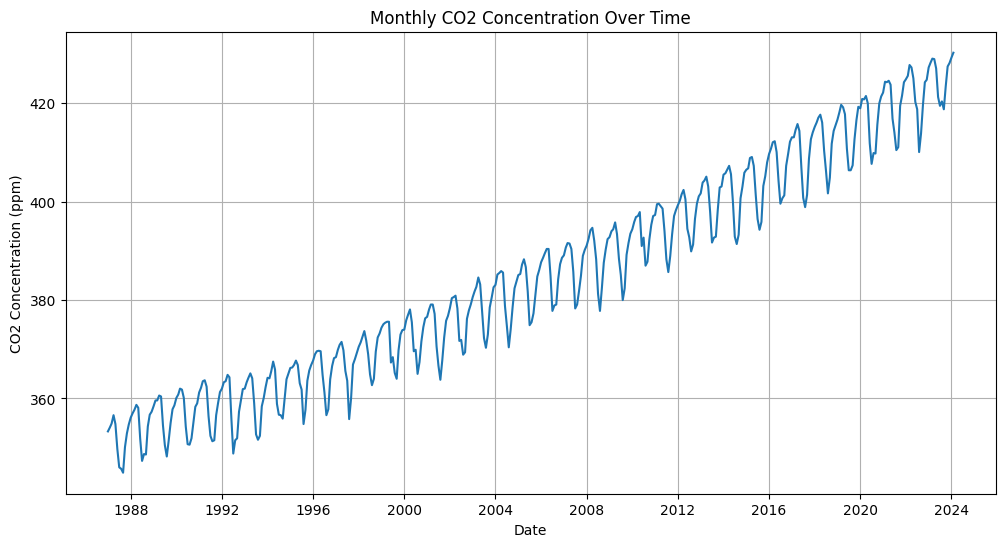

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
plt.grid(True)
SRC_GRAPH_1_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_1.jpg'
plt.savefig(SRC_GRAPH_1_PATH)


- 右肩上がりである。つまり単調に増加するというトレンドがある。
- 1年周期を持つ。

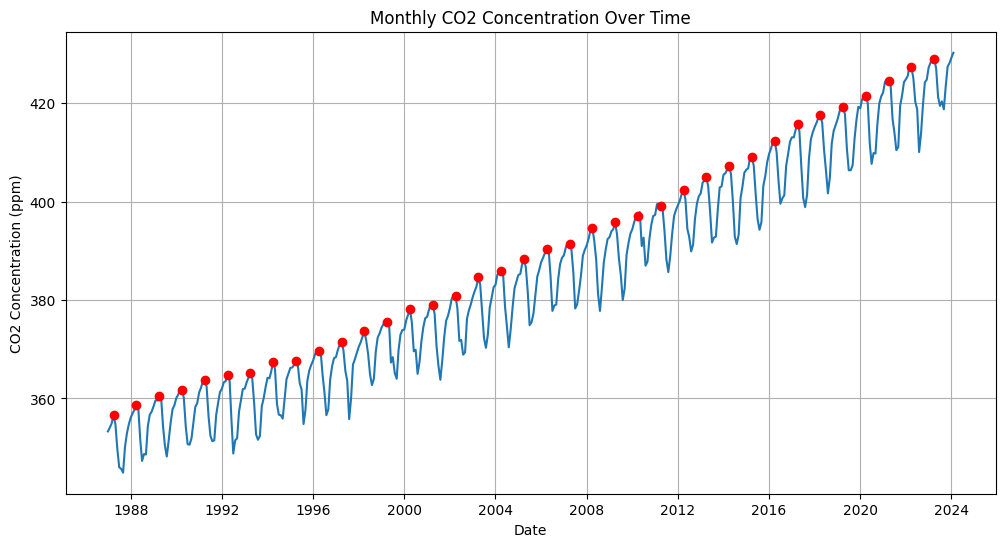

In [4]:
# Extract only the rows corresponding to April for drawing vertical lines
april_dates = data[data['date'].dt.month == 4]['date']

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates
plt.plot(april_dates, data[data['date'].dt.month == 4]['co2'], 'o', color='red')
plt.grid(True)
SRC_GRAPH_2_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_2.jpg'
plt.savefig(SRC_GRAPH_2_PATH)


- 4月に極大値がある（赤丸）。

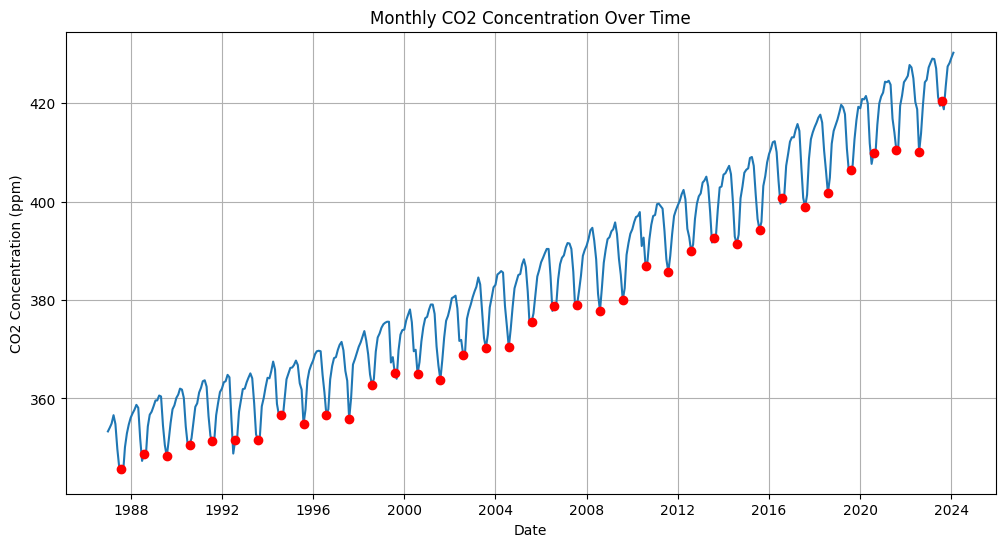

In [5]:
aug_dates = data[data['date'].dt.month == 8]['date']
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates
plt.plot(aug_dates, data[data['date'].dt.month == 8]['co2'], 'o', color='red')
plt.grid(True)
SRC_GRAPH_4_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_4.jpg'
plt.savefig(SRC_GRAPH_4_PATH)


- 8月に極小値がある（赤丸）。

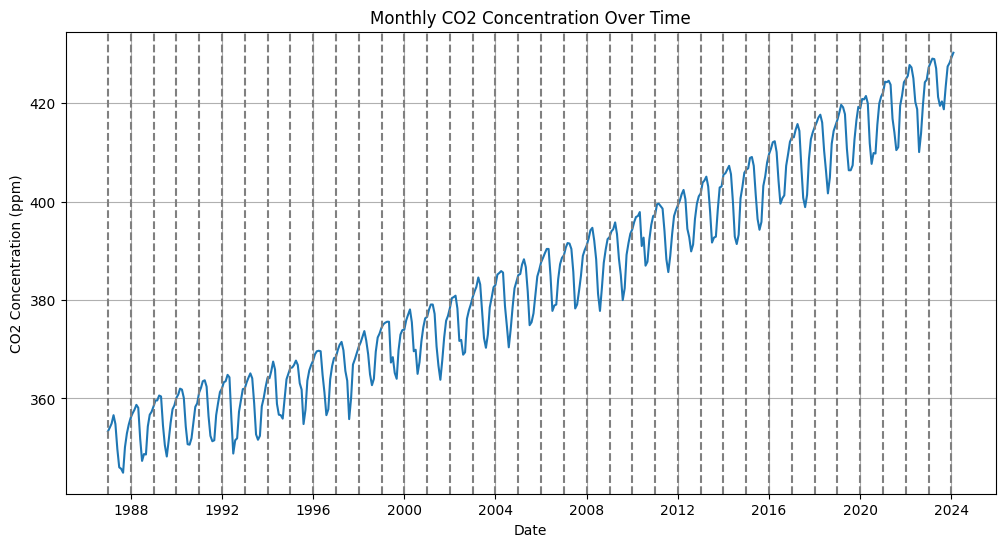

In [6]:
# Extract only the rows corresponding to April for drawing vertical lines
jan_dates = data[data['date'].dt.month == 1]['date']

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates

# Add vertical dashed lines at every April
for jan_date in jan_dates:
    plt.axvline(x=jan_date, color='gray', linestyle='--')

plt.grid(True)
SRC_GRAPH_3_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_3.jpg'
plt.savefig(SRC_GRAPH_3_PATH)


- 垂直な点線間は1年を示す。つまり季節的な周期がある。

### 時系列分解

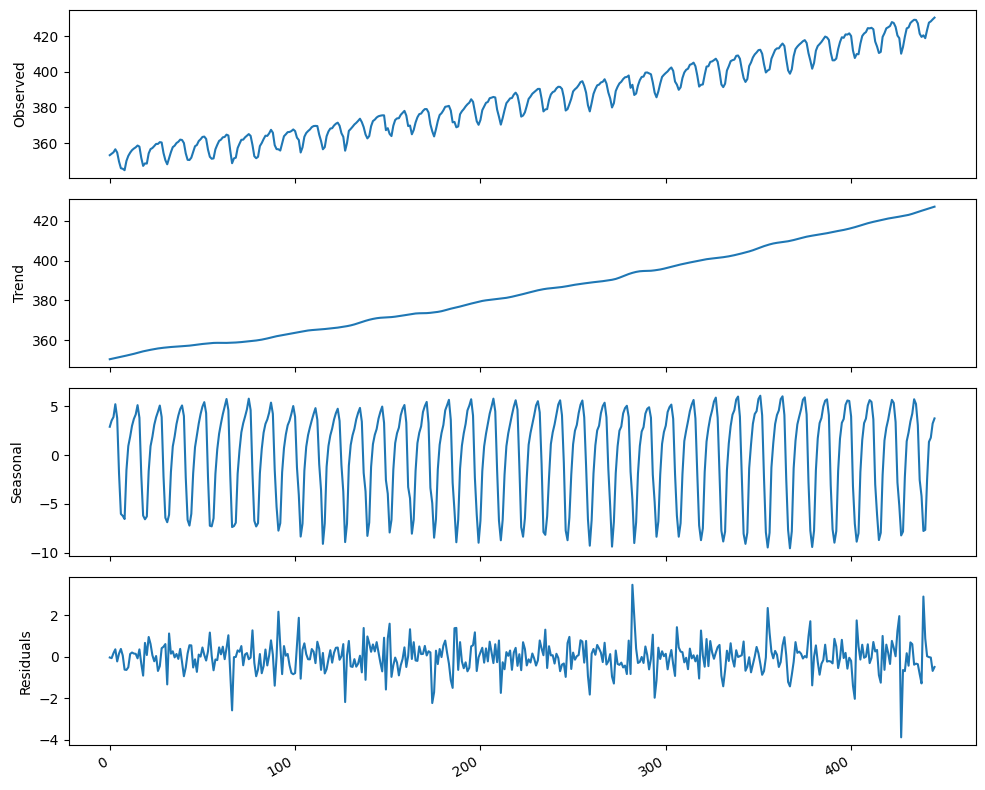

In [7]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(data['co2'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

#plt.xticks(np.arange(0, 447, 12), np.arange(1988, 2024, 1))

fig.autofmt_xdate()
plt.tight_layout()

DECOM_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/decomposition.jpg'
plt.savefig(DECOM_PATH, dpi=300)

上のグラフから以下を読み取れる。
- 単調増加するトレンドがある。
- 年周期の変動がある。
- これらを取り除いた残差は無相関（ホワイトノイズ）に見える。

### SARIMAモデルによる予測

定常データに変換する。

In [8]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(data['co2'])
criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: 2.3490677243905096
p-value: 0.9989842880293069
critical 1%: -3.445613745346461
critical 5%: -2.868269325317112
critical 10%: -2.5703544951308404


- [0.05の意味](https://bellcurve.jp/statistics/course/9313.html?srsltid=AfmBOooRsLq0701sniZPd76THgzn7VKesLXxmbxBptEC_f2ohqqlKA36)

- [臨界値の意味](https://note.com/united_code/n/n6553701404de)
上の結果より
- ADF統計量がどの臨界値より大きい。
- p値が0.05より大きい。

従って、時系列そのものは定常ではない。次に1次差分を取る。

In [9]:
df_diff = np.diff(data['co2'], n=1)

ad_fuller_result = adfuller(df_diff)

criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: -7.044837391957347
p-value: 5.722230484233865e-10
critical 1%: -3.445613745346461
critical 5%: -2.868269325317112
critical 10%: -2.5703544951308404


- ADF統計量が臨界値よりも小さい。
- p値が0.05より小さい。

上の結果から1次差分は定常である。季節性は先に見たから$(D,d)=(1,1)$として$(p,q,P,Q)$の値を探す。

In [18]:
from itertools import product
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
d = 1
D = 1
s = 12
SARIMA_order_list = list(product(ps, qs, Ps, Qs))


In [26]:
from itertools import product
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Ds = range(0, 2, 1)
Qs = range(0, 4, 1)
d = 1
s = 12
SARIMA_order_list = list(product(ps, qs, Ps, Ds, Qs))


In [19]:
SARIMA_order_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [23]:
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA_(endog: Union[pd.Series, list], order_list: list, d: int, s: int) -> pd.DataFrame:

    results = []

    for order in order_list:
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], order[3], order[4], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic # type:ignore
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,D,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [11]:
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in order_list:
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic # type:ignore
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [12]:
# 訓練データとテストデータに分ける。
OFFSET = 24
train = data['co2'][:-OFFSET]
test = data.iloc[-OFFSET:]

In [27]:
SARIMA_result_df = optimize_SARIMA_(train, SARIMA_order_list, d, s)
SARIMA_result_df

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

,"(p,q,P,D,Q)",AIC
0,"(3, 1, 1, 1, 1)",1280.757347
1,"(3, 1, 0, 1, 2)",1281.495642
2,"(3, 1, 1, 1, 2)",1282.441148
3,"(3, 1, 2, 1, 1)",1282.507851
4,"(3, 2, 1, 1, 1)",1282.560391
...,...,...
505,"(0, 2, 0, 0, 0)",2054.003616
506,"(1, 1, 0, 0, 0)",2058.011852
507,"(1, 0, 0, 0, 0)",2063.810706
508,"(0, 1, 0, 0, 0)",2069.193529


最適な値は次の通り。
$(p,q,P,Q)=(3,1,1,1)$

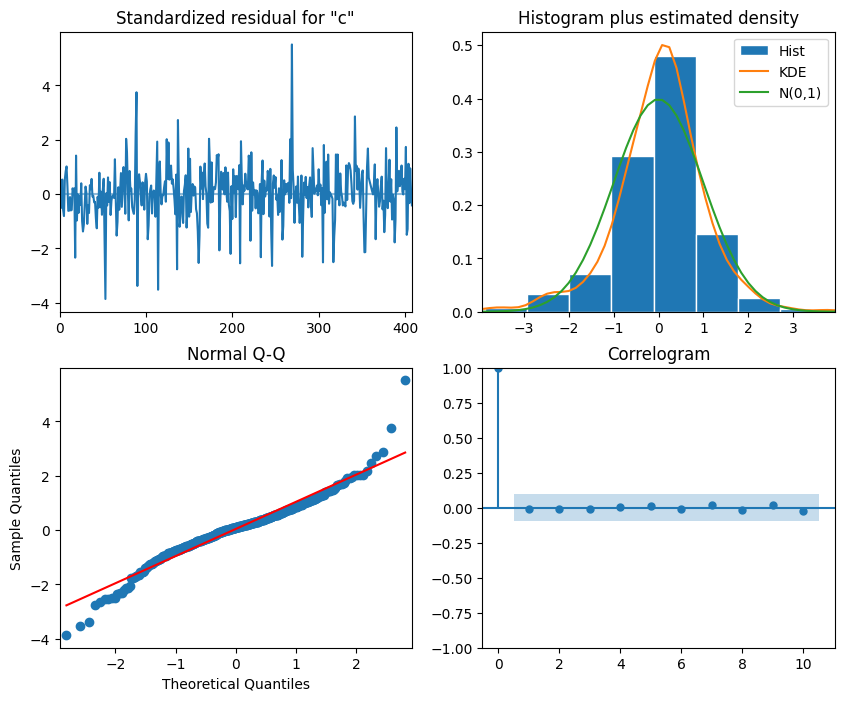

In [13]:
(p,d,q) = (3,1,1)
(P,D,Q,s) = (1,1,1,12)
SARIMA_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P,D,Q,s), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8)) # type: ignore
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/diagnostics.jpg', dpi=300)

- 左上図：振動の中心はゼロ近傍、振幅は全領域を通してほぼ同じ。つまり分散に変化がない。
- 右上図：残差分布は正規分布に従う。
- 左下図：Q-Qプロット。ほぼ直線。両端のずれは気になるけれど。
- 右下図：コレログラム。ラグ0の後に有意な自己相関係数がない。
以上の考察から、このモデルの残差はホワイトノイズに似ていると言える。

リュング・ボックス検定

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid # type: ignore
result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,0.000072,0.993227
2,0.000319,0.999841
3,0.000681,0.999995
4,0.006874,0.999994
5,0.049850,0.999971
6,0.052688,0.999997
7,0.062256,1.000000
8,0.062466,1.000000
9,0.096008,1.000000
10,0.108761,1.000000


上の$p$値はすべて0.05を超えている。したがって、残差は無相関である。つまり、SARIMA(3,1,1)(1,1,1)_12で表現できる。

### 予測

In [21]:
guideline = data.iloc[-2*OFFSET:]

In [22]:
SARIMA_pred = SARIMA_model_fit.get_prediction(422, 445).predicted_mean # type: ignore
test["SARIMA_pred"] = SARIMA_pred

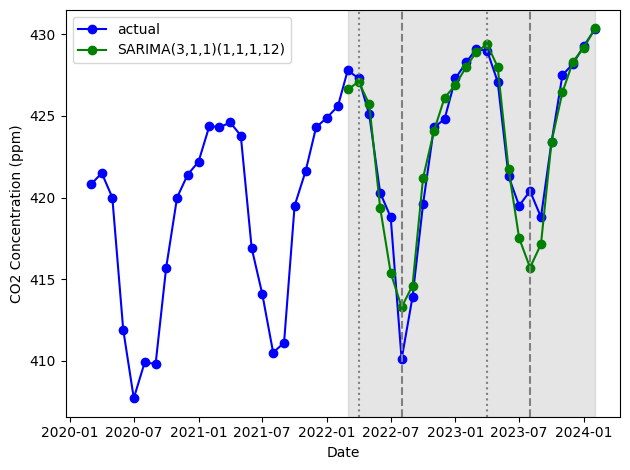

In [23]:
fig, ax = plt.subplots()


ax.plot(guideline['date'], guideline['co2'], 'b-', label='actual',marker='o')
ax.plot(test['date'], test['SARIMA_pred'], 'g-', label="SARIMA(3,1,1)(1,1,1,12)", marker='o')
#ax.plot(test['date'], test['SARIMA_pred_d_0'], 'g-', label="SARIMA(1,0,2)(1,1,1,12)", marker='o')
#ax.plot(test['date'], test['ARIMA_pred_2nd'], 'r-', label="ARIMA(10,2,12)(0,0,12)", marker='o')

aug_dates = test[test['date'].dt.month == 8]['date']
april_dates = test[test['date'].dt.month == 4]['date']

for aug_date in aug_dates:
    ax.axvline(x=aug_date, color='gray', linestyle='--')

for april_date in april_dates:
    ax.axvline(x=april_date, color='gray', linestyle=':')

ax.axvspan(test['date'].iloc[0], test['date'].iloc[-1], color='#808080', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend(loc='best')
fig.autofmt_xdate
plt.tight_layout()
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/prediction_3.jpg', dpi=300)


- 垂直な点線：4月
- 垂直な破線：8月

In [29]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mape_SARIMA = mape(test['co2'], test['SARIMA_pred'])
print(mape_SARIMA)

0.25432273810544875
